In [1]:
import os
import pickle
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
import numpy as np

import matplotlib.pyplot as plt
from collections import Counter
# import tifffile as tiff

In [2]:
# Function to load data from a directory
def load_data_from_directory(directory):
    images = []
    labels = []
    for filename in os.listdir(directory):
        with open(os.path.join(directory, filename), 'rb') as f:
            image, label = pickle.load(f)
            # Reshape or reorder image data if necessary (bands, height, width -> height, width, bands)
            image = np.transpose(image, (1, 2, 0))
            images.append(image)
            labels.append(label)
    return np.array(images), np.array(labels)

# Paths to your data directories
train_dir = "data/classification_dataset/train"
validation_dir = "data/classification_dataset/validation"
test_dir = "data/classification_dataset/test"

# Load the data
train_images, train_labels = load_data_from_directory(train_dir)
val_images, val_labels = load_data_from_directory(validation_dir)
test_images, test_labels = load_data_from_directory(test_dir)

# Convert data to tf.data.Dataset
def create_tf_dataset(images, labels):
    dataset = tf.data.Dataset.from_tensor_slices((images, labels))
    return dataset

train_dataset = create_tf_dataset(train_images, train_labels)
validation_dataset = create_tf_dataset(val_images, val_labels)
test_dataset = create_tf_dataset(test_images, test_labels)

# Batch and shuffle the datasets
BATCH_SIZE = 32

train_dataset = train_dataset.shuffle(buffer_size=1000).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
validation_dataset = validation_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

(32, 32, 12) 1


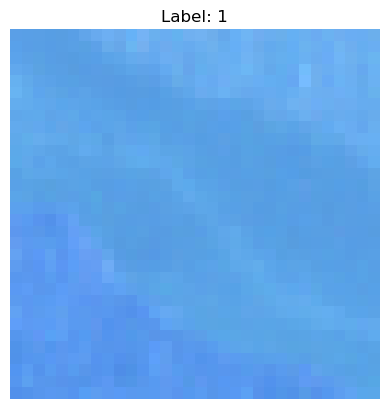

In [3]:
for images, labels in train_dataset.take(1):
    for i in range(1):
        print(images[i].shape, labels[i].numpy())
        image = images[i]
        label = labels[i]

        # Reshape or reorder image data if necessary (bands, height, width -> height, width, bands)
        #image = np.transpose(image, (1, 2, 0))  # (12, 32, 32) -> (32, 32, 12)

        # Select RGB bands (e.g., bands 4, 3, 2 from Sentinel-2, adjust if needed)
        rgb_image = np.stack([
            image[:, :, 3],  # Band 4 (Red)
            image[:, :, 2],  # Band 3 (Green)
            image[:, :, 1]   # Band 2 (Blue)
        ], axis=-1)
        
        # Normalize the RGB image for saving
        rgb_image = (rgb_image / np.max(rgb_image) * 255).astype(np.uint8)

        # Save the image as a TIFF file
        # tiff.imwrite('rgb_image.tiff', rgb_image)
        # print("Image saved as 'rgb_image.tiff'")

        # Display the RGB image
        plt.imshow(rgb_image)
        plt.title(f"Label: {label.numpy()}")
        plt.axis("off")
        plt.show()


In [4]:
#Use class weights in model to re-balance the data

In [5]:
#Size of training data
for image_batch, labels_batch in train_dataset.take(1):
  print(image_batch.shape)
  print(labels_batch.shape)

(32, 32, 32, 12)
(32,)


In [6]:
TARGET_SHAPE = (-1, 32, 32,12)

def reshape_tensors(image_batch, labels_batch):
    image_batch = tf.reshape(image_batch, shape=TARGET_SHAPE)
    return image_batch, labels_batch

#train_dataset = train_dataset.map(reshape_tensors, num_parallel_calls=tf.data.AUTOTUNE)
#validation_dataset = validation_dataset.map(reshape_tensors, num_parallel_calls=tf.data.AUTOTUNE)
#test_dataset = test_dataset.map(reshape_tensors, num_parallel_calls=tf.data.AUTOTUNE)


In [7]:
for image_batch, labels_batch in train_dataset.take(1):
  print(image_batch.shape)
  print(labels_batch.shape)

(32, 32, 32, 12)
(32,)


In [8]:
img_height = 32
img_width = 32

In [9]:
batch_size = 32

In [10]:
num_classes = 2

model = Sequential([
  layers.Conv2D(16, 12, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 12, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 12, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [11]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [12]:
#Input to reshape is a tensor with 380928 values, but the requested shape has 393216

test = 380928/(32*32*12)
print(test)

31.0


In [13]:
model.summary()

ValueError: This model has not yet been built. Build the model first by calling `build()` or by calling the model on a batch of data.

In [ ]:
epochs=10
history = model.fit(
  train_dataset,
  validation_data=validation_dataset,
  epochs=epochs
)

#no_classweights_10_ephocs

Epoch 1/10
1673/1673 [==============================] - 123s 73ms/step - loss: 0.2905 - accuracy: 0.8525 - val_loss: 0.5748 - val_accuracy: 0.5000
Epoch 2/10
1673/1673 [==============================] - 128s 77ms/step - loss: 0.2717 - accuracy: 0.8569 - val_loss: 0.6153 - val_accuracy: 0.5416
Epoch 3/10
1673/1673 [==============================] - 131s 79ms/step - loss: 0.2587 - accuracy: 0.8674 - val_loss: 0.5344 - val_accuracy: 0.5897
Epoch 4/10
1673/1673 [==============================] - 137s 82ms/step - loss: 0.2526 - accuracy: 0.8713 - val_loss: 0.5454 - val_accuracy: 0.5584
Epoch 5/10
1673/1673 [==============================] - 138s 83ms/step - loss: 0.2528 - accuracy: 0.8705 - val_loss: 0.5092 - val_accuracy: 0.5824
Epoch 6/10
1673/1673 [==============================] - 157s 94ms/step - loss: 0.2499 - accuracy: 0.8720 - val_loss: 0.5539 - val_accuracy: 0.5703
Epoch 7/10
1673/1673 [==============================] - 148s 89ms/step - loss: 0.2524 - accuracy: 0.8723 - val_loss: 0

In [ ]:
# Save the entire model as a `.keras` zip archive.
model.save('no_classweights_10_epochs.keras')

## Training with class weights

In [14]:
def calculate_class_weights(dataset):
    # Extract all labels from the dataset
    all_labels = []
    for _, labels in dataset:
        all_labels.extend(labels.numpy())

    # Count the occurrences of each class
    label_counts = Counter(all_labels)

    # Total number of samples
    total_samples = sum(label_counts.values())

    # Calculate weights for each class
    class_weights = {label: total_samples / (len(label_counts) * count) 
                     for label, count in label_counts.items()}

    return class_weights

# Calculate class weights for the train_dataset
class_weights = calculate_class_weights(train_dataset)
print("Class Weights:", class_weights)

Class Weights: {0: 0.5864792620670012, 1: 3.390866480871548}


In [ ]:
epochs=10
history = model.fit(
  train_dataset,
  validation_data=validation_dataset,
  epochs=epochs,
  class_weight = class_weights
)

Epoch 1/10


2024-11-22 12:53:10.132565: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


1673/1673 [==============================] - 4548s 3s/step - loss: 0.4030 - accuracy: 0.7035 - val_loss: 0.3836 - val_accuracy: 0.8271
Epoch 2/10
1673/1673 [==============================] - 134s 80ms/step - loss: 0.3923 - accuracy: 0.7066 - val_loss: 0.3919 - val_accuracy: 0.8233
Epoch 3/10
 248/1673 [===>..........................] - ETA: 39:59 - loss: 0.3817 - accuracy: 0.7077

In [ ]:
model.save('with_classweights_10_epochs.keras')

### To do some visualizations!